

q1



In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

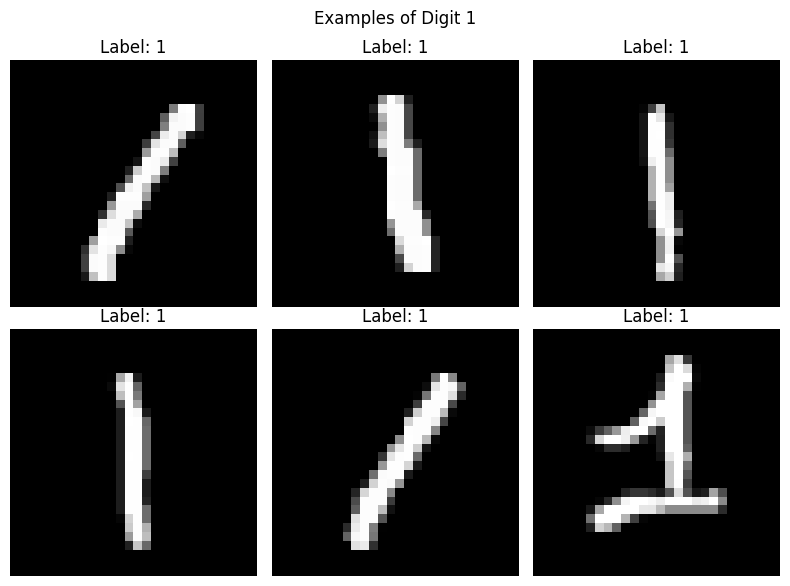

In [6]:
def visualize_digit(dataset, digit=1, num_examples=6):
    digit_indices = [i for i, (_, label) in enumerate(dataset) if label == digit]

    fig, axes = plt.subplots(2, 3, figsize=(8, 6))
    fig.suptitle(f'Examples of Digit {digit}')

    for i, ax in enumerate(axes.flat):
        idx = digit_indices[i]
        image, label = dataset[idx]
        image = image.squeeze()
        ax.imshow(image, cmap='gray')
        ax.set_title(f'Label: {label}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

visualize_digit(train_dataset, digit=1)

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
    return running_loss / len(train_loader), 100 * correct / total

def test_epoch(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)

            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    return running_loss / len(test_loader), 100 * correct / total

In [9]:
#training
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(10):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    test_loss, test_acc = test_epoch(model, test_loader, criterion)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1}:")
    print(f"  Training Loss: {train_loss}, Training Accuracy: {train_acc}%")
    print(f"  Test Loss: {test_loss}, Test Accuracy: {test_acc}%")

Epoch 1:
  Training Loss: 0.16431691712696853, Training Accuracy: 94.885%
  Test Loss: 0.05017596548816165, Test Accuracy: 98.34%
Epoch 2:
  Training Loss: 0.05302811776702878, Training Accuracy: 98.385%
  Test Loss: 0.03308606607942626, Test Accuracy: 98.85%
Epoch 3:
  Training Loss: 0.038988129193017106, Training Accuracy: 98.77%
  Test Loss: 0.029915826114983286, Test Accuracy: 98.96%
Epoch 4:
  Training Loss: 0.03067667767249007, Training Accuracy: 99.03666666666666%
  Test Loss: 0.03170165201258115, Test Accuracy: 98.94%
Epoch 5:
  Training Loss: 0.02339607883884665, Training Accuracy: 99.26833333333333%
  Test Loss: 0.026427272369749222, Test Accuracy: 99.1%
Epoch 6:
  Training Loss: 0.01966689848179084, Training Accuracy: 99.325%
  Test Loss: 0.03542252440414362, Test Accuracy: 98.99%
Epoch 7:
  Training Loss: 0.01796921739977111, Training Accuracy: 99.41%
  Test Loss: 0.030295233398416544, Test Accuracy: 99.11%
Epoch 8:
  Training Loss: 0.016145866160804715, Training Accuracy: 

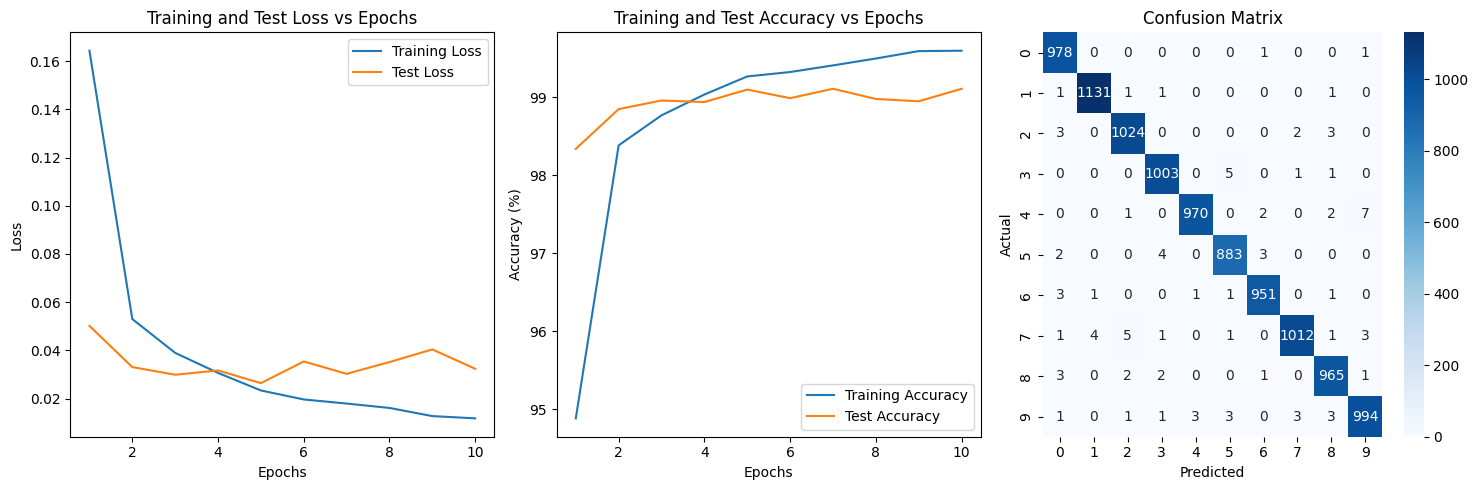

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

epochs = range(1, 11)
axes[0].plot(epochs, train_losses, label='Training Loss')
axes[0].plot(epochs, test_losses, label='Test Loss')
axes[0].set_title('Training and Test Loss vs Epochs')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(epochs, train_accuracies, label='Training Accuracy')
axes[1].plot(epochs, test_accuracies, label='Test Accuracy')
axes[1].set_title('Training and Test Accuracy vs Epochs')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy (%)')
axes[1].legend()

model.eval()
all_predictions = []
all_targets = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, predicted = torch.max(output, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

cm = confusion_matrix(all_targets, all_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[2],
            xticklabels=range(10), yticklabels=range(10))
axes[2].set_title('Confusion Matrix')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')

plt.tight_layout()
plt.show()